## 线性回归

我们对计算进行矢量化，从而利用线性代数库，而不是在Python中编写开销高昂的for循环

In [1]:
import math
import time
import numpy as np
import torch
import d2l.torch as d2l

对向量相加的两种方法

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

我们定义一个计时器

In [3]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

我们使用for循环，每次执行一位的加法

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.14015 sec'

或者，我们使用重载的+运算符来计算按元素的和

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00022 sec'

我们定义一个Python函数来计算正态分布

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 / sigma ** 2 * (x - mu)**2)

可视化正态分布

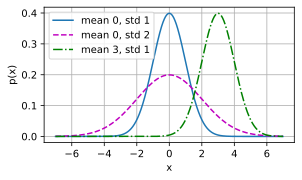

In [7]:
x = np.arange(-7, 7, 0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', 
         ylabel='p(x)', figsize=(4.5, 2.5),
        legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 线性回归的从零开始实现

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [8]:
import random
import torch
import d2l.torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$\mathbf{W}=[2, -3.4]$、$b=4.2$和噪声项$\varepsilon$生成数据集及其标签：

$$
\mathbf{y} = \mathbf{X} \mathbf{w} + b + \varepsilon
$$

In [9]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

feature中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值(一个标量)。

In [10]:
print('features', features, '\nlabels', labels[0])

features tensor([[ 0.9684,  1.9346],
        [-0.6033,  0.1022],
        [-0.4582,  0.9254],
        ...,
        [ 1.3906, -0.7114],
        [ 0.1502,  0.2473],
        [ 0.4944, -0.8332]]) 
labels tensor([-0.4486])


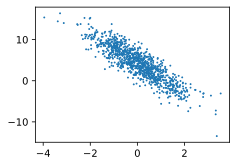

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

定义一个data_iter函数，该函数接收批量大小，特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.2547e-01, -1.5517e-01],
        [-1.5894e-01,  6.1712e-01],
        [-1.7532e+00, -6.8377e-01],
        [-1.7237e+00, -7.3124e-01],
        [ 9.1670e-02, -1.0906e+00],
        [ 7.1810e-01, -1.3487e-03],
        [-6.7659e-01, -7.6451e-01],
        [-4.7056e-01, -1.1373e-01],
        [ 8.9554e-01, -1.3489e-01],
        [ 6.7540e-01,  2.7927e+00]]) 
 tensor([[ 5.1777],
        [ 1.7791],
        [ 3.0293],
        [ 3.2088],
        [ 8.0904],
        [ 5.6437],
        [ 5.4587],
        [ 3.6574],
        [ 6.4501],
        [-3.9573]])


定义初始化模型参数

In [13]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [14]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

定义损失函数

In [15]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [16]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}')

epoch 1, loss  0.032419
epoch 2, loss  0.000119
epoch 3, loss  0.000052


比较真实参数和通过训练学到的参数来评估训练的成功度

In [18]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([ 0.0002, -0.0006], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0006], grad_fn=<RsubBackward1>)
